[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/test7.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
# general
import os
import numpy as np
from tqdm import tqdm
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
import arviz
from getdist import plots, MCSamples
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# # NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development notebook 7
$\providecommand{\d}{\mathrm{d}}$
$\providecommand{\D}{\mathcal{D}}$

Let's work in $n$ dimensional space.

$$
Z = \int  \d x e^{i (x^2 - 2xy)} = \int\d x e^{i(x-y)^2-iy^2} = e^{-iy^2} \left[(1+i)\sqrt{\pi/2}\right]^n = e^{-iy^2}e^{in\pi/4}\pi^{n/2}
$$

After PL

$$
Z = \int \d x \left|\frac{\partial z}{\partial x}\right| e^{i (x^2 - 2xy)} = \int \d x |Je^{h(x, y)}| e^{iH+i\varphi_J}
$$

The goal is to find the conditional probability distribution $P(x|y)$ that is proportional to $|Je^{h}|$.

This notebooks use $n=2$

In [3]:
def action_iphi(z, y):
    z2 = jnp.dot(z, z)
    zy = jnp.dot(z, y)
    iphi = 1j*(z2 - 2*zy)
    return iphi

def action_h(z, y):
    s = action_iphi(z, y)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z, y):
    seff = -action_iphi(z, y)
    return seff

def integrand(z, y):
    return jnp.exp(action_iphi(z, y))

# corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [4]:
def flow_step(z, y, ds, thre=0.1):
    dSdz = grad_Seff(z, y)
    z = z + ds*jnp.conj(dSdz)
    return z

def flow_n_steps(x, y, ds, n_step):
    z = x.astype(complex)
    fnc = lambda z, null: (flow_step(z, y, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(x, y, ds, n_step):
    z = flow_n_steps(x, y, ds, n_step)
    # Jacobian (we do this because the func is complex)
    def split(x, y, ds, n_step):
        f = flow_n_steps(x, y, ds, n_step)
        return jnp.real(f), jnp.imag(f)
    j = jacobian(split, argnums=0)(x, y, ds, n_step)
    j = j[0] + j[1]*1j
    j = jnp.linalg.det(j)

    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None,None), 0)

In [6]:
def model():
    # Define a prior for `x`
    x = []
    for i in range(ndim):
        xi = numpyro.sample('x{}'.format(i+1), npyro_dist.Uniform(-5, 5))
        x.append(xi)
    x = jnp.array(x)

    # context param
    y = []
    for i in range(ndim):
        yi = numpyro.sample('y{}'.format(i+1), npyro_dist.Uniform(-4, 4))
        y.append(yi)
    y = jnp.array(y)

    # flow
    # n_step in flow should be optimized depending on the dimension...
    z_pl, j = flow_n_steps_with_jac(x, y, 1e-3, 400)
    i = integrand(z_pl, y)

    amplt = jnp.abs(i*j)
    phase = i*j/amplt

    # likelihood
    numpyro.factor('loglike', jnp.log(amplt))

    # save derived parameters
    numpyro.deterministic('phase'    , phase)
    numpyro.deterministic('amplitude', amplt)


In [7]:
ndim = 2
# Set up and run the HMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=10000)
mcmc.run(jax.random.PRNGKey(0))

# Get samples
samples_raw = mcmc.get_samples()
# convert to jnp
# samples = jnp.transpose(jnp.array([samples_raw['x{}'.format(i+1)] for i in range(ndim)]))
# samples = jnp.transpose(jnp.array([samples_raw['x1'] , samples_raw['y'][:,0]]))
# samples = jnp.transpose(jnp.array([samples_raw['x1'] , samples_raw['y']]))
samples = jnp.transpose(jnp.array([samples_raw['x{}'.format(i+1)] for i in range(ndim)] +\
                                    [samples_raw['y{}'.format(i+1)] for i in range(ndim)]))

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
  0%|          | 0/10500 [00:00<?, ?it/s]/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:20<00:00, 501.58it/s, 63 steps of size 9.12e-02. acc. prob=0.95]


Removed no burn in


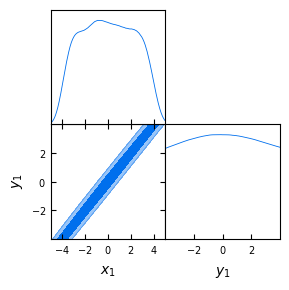

In [8]:
names = ['x{}'.format(i+1) for i in range(ndim) ] + ['y{}'.format(i+1) for i in range(ndim) ]
labels= ['x_{}'.format(i+1) for i in range(ndim)] + ['y_{}'.format(i+1) for i in range(ndim)]
ranges= {name: (-5,5) if 'x' in name else (-4,4) for name in names}
mcsamples = MCSamples(samples=samples, names=names, labels=labels, ranges=ranges)
g = plots.get_subplot_plotter(width_inch=3)
g.triangle_plot(mcsamples, ['x1', 'y1'], filled=True)
plt.show()

Now we train the conditional probability $P(x|y)$ from the samples.

In [9]:
import flax.linen as nn
import optax
from sklearn import datasets, preprocessing
from tqdm import tqdm

import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

In [10]:
n_dim = ndim
n_context = ndim  # Single context parameter  

# flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=12, activation="tanh", use_random_permutations=False)
flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=8, activation="tanh", use_random_permutations=False)
# flow_model = NeuralSplineFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=8, activation="gelu", n_bins=16, range_min=-2, range_max=2,)
# flow_model = NeuralSplineFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[32,32], n_transforms=4, activation="gelu", n_bins=16, range_min=-2, range_max=2,)

# Initialize model
key = jax.random.PRNGKey(42)
x_test = jax.random.uniform(key=key, shape=(64, n_dim))
context = jax.random.uniform(key=key, shape=(64, n_context))
params = flow_model.init(key, x_test, context)

In [11]:
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(params)

def loss_fn(params, x, context):
    loss = -jnp.mean(flow_model.apply(params, x, context))
    return loss

@jax.jit
def update(params, opt_state, batch):
    x, context = batch
    grads = jax.grad(loss_fn)(params, x, context)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [12]:
batch_size = 64
n_steps = 10_000

for step in tqdm(range(n_steps)):
    # Generate random batch
    data_batch = samples[np.random.choice(samples.shape[0], batch_size)]
    x_batch = data_batch[:,:ndim]
    y_batch = data_batch[:,ndim:]

    # Update
    batch = (x_batch, y_batch)
    params, opt_state = update(params, opt_state, batch)

100%|██████████| 10000/10000 [03:28<00:00, 47.91it/s]


In [13]:
def sample_from_flow(y, n_samples=10_000, key=jax.random.PRNGKey(42)):
    """Helper function to sample from the flow model.
    """
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context)

    def sample_fn(flow_model):
        x_samples = flow_model.sample(num_samples=n_samples, rng=key, 
                        context=y)
        return x_samples

    x_samples = nn.apply(sample_fn, flow_model)(params)
    x_samples = jnp.array(x_samples)
    return x_samples

In [14]:
y = jnp.arange(10_000 * 2).reshape(10_000, 2)
x = sample_from_flow(y, n_samples=10_000)
y.shape, x.shape

((10000, 2), (10000, 2))

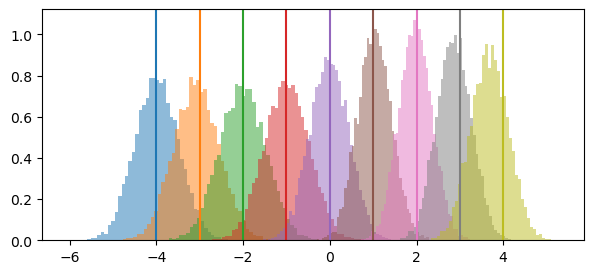

In [15]:
plt.figure(figsize=(7, 3))
for j, y in enumerate([-4, -3, -2, -1, 0, 1, 2, 3, 4]):
    _ = jnp.array([y, 0])
    x = sample_from_flow(y=_, n_samples=10_000, key=jax.random.PRNGKey(42))
    plt.hist(x[:,0], bins=50, density=True, alpha=0.5, label="Flow", color='C{}'.format(j))
    plt.axvline(y, color='C{}'.format(j))
plt.show()

In [16]:
n_samples = 10_000
y_flow = jax.random.uniform(key=jax.random.PRNGKey(40), shape=(n_samples,n_context), minval=-4, maxval=4)
x_flow = sample_from_flow(y=y_flow, n_samples=n_samples, key=jax.random.PRNGKey(42))

Removed no burn in
Removed no burn in


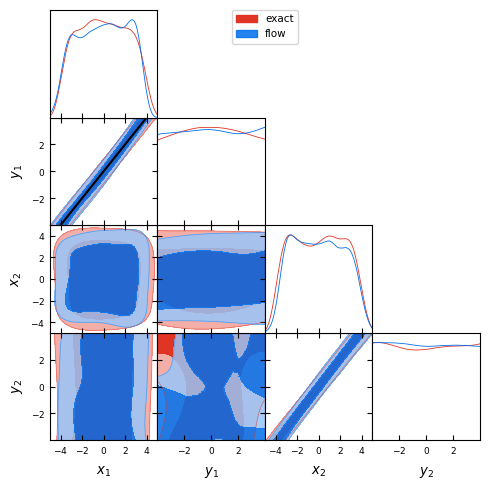

In [17]:
mcsamples = MCSamples(samples=samples, names=names, labels=labels, ranges=ranges, label='exact')
mcsamples_flow = MCSamples(samples=np.hstack([x_flow, y_flow]), names=names, labels=labels, ranges=ranges, label='flow')
g = plots.get_subplot_plotter(width_inch=5)
g.triangle_plot([mcsamples, mcsamples_flow], ['x1', 'y1', 'x2', 'y2'], filled=True, alpha=0.6)
ax = g.get_axes((1,0))
_ = np.linspace(-4,4, 10)
ax.plot(_,_, color='k')
plt.show()

Okay!

In [18]:
def log_prob_from_flow(x, y):
    """Helper function to evaluate logprob
    """
    if len(x.shape) == 1:
        n_samples = 1
        x = jnp.ones((n_samples, n_dim))*x[None, :]
    else:
        n_samples = x.shape[0]
    assert x.shape == (n_samples, n_dim)
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context)
    
    def logprob_fn(flow_model):
        x_samples = flow_model(x, y)
        return x_samples

    log_prob = nn.apply(logprob_fn, flow_model)(params)
    return log_prob

In [28]:
y1 = jnp.pi**0.5
y2 = 0.0
y_flow = jnp.array([y1, y2])
y_sample = y_flow
%time x_flow = sample_from_flow(y=y_sample, n_samples=10_000, key=jax.random.PRNGKey(42))
%time logp = log_prob_from_flow(x_flow, y_flow)

CPU times: user 407 ms, sys: 65.4 ms, total: 472 ms
Wall time: 383 ms
CPU times: user 632 ms, sys: 76.1 ms, total: 708 ms
Wall time: 441 ms


In [29]:
%time z_pl, j = vflow(x_flow, y_flow, 1e-3, 400)
%time i = vmap(integrand, (0, None), 0)(z_pl, y_flow)
Z_pl = jnp.mean( i*j*jnp.exp(-logp) )

CPU times: user 276 ms, sys: 21.6 ms, total: 298 ms
Wall time: 311 ms
CPU times: user 3.38 ms, sys: 493 µs, total: 3.88 ms
Wall time: 3.82 ms


In [30]:
Z_ana = jnp.exp(-1j*jnp.dot(y_flow,y_flow)) * ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim

In [31]:
print('Z_pl :', Z_pl)
print('Z_ana:', Z_ana)

Z_pl : (-0.0072022686-3.139013j)
Z_ana: (-2.3129458e-07-3.1415927j)


In [33]:
def eval_Z_pl(y, x_flow=None, logp=None):
    y_flow = y
    if x_flow is None:
        x_flow = sample_from_flow(y=y_flow, n_samples=10_000, key=jax.random.PRNGKey(42))
    if logp is None:
        logp = log_prob_from_flow(x_flow, y_flow)

    z_pl, j = vflow(x_flow, y_flow, 1e-3, 400)
    i = vmap(integrand, (0, None), 0)(z_pl, y_flow)

    Z_pl = jnp.mean( i*j*jnp.exp(-logp) )

    return Z_pl

In [34]:
y1 = jnp.linspace(-2, 2, 100)
y2 = jnp.zeros_like(y1)
y = jnp.transpose(jnp.array([y1, y2]))

In [35]:
%time Z_pl = vmap(eval_Z_pl)(y)

CPU times: user 1min 46s, sys: 1min 17s, total: 3min 3s
Wall time: 58.5 s


In [36]:
Z_ana = jnp.exp(-1j*jnp.sum(y**2, axis=1)) * ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim

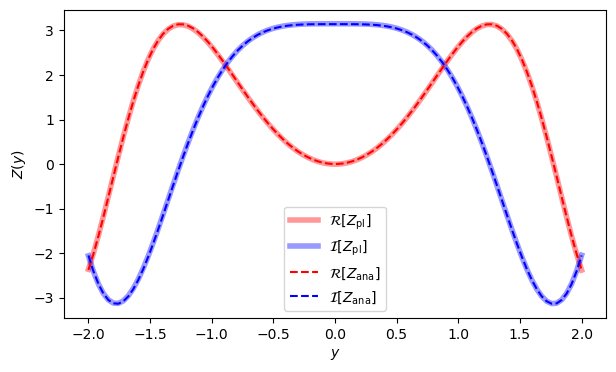

In [37]:
plt.figure(figsize=(7, 4))
plt.plot(y1, jnp.real(Z_pl) , 'r-' , label=r'$\mathcal{R}[Z_{\rm pl}]$', alpha=0.4, lw=4)
plt.plot(y1, jnp.imag(Z_pl) , 'b-' , label=r'$\mathcal{I}[Z_{\rm pl}]$', alpha=0.4, lw=4)
plt.plot(y1, jnp.real(Z_ana), 'r--', label=r'$\mathcal{R}[Z_{\rm ana}]$')
plt.plot(y1, jnp.imag(Z_ana), 'b--', label=r'$\mathcal{I}[Z_{\rm ana}]$')
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.legend()
plt.show()